In [1]:
# -*- coding: utf-8 -*-
files = [
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/result_collection/1b_steps/test.bulk.tsv.response.valid.structures/reasonable_structures_with_bulk_modules.csv",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/result_collection/8b_steps/test.bulk.tsv.response.valid.structures/reasonable_structures_with_bulk_modules.csv",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/result_collection/8x7b/global_step7755_restore_new/test.bulk.response.valid.structures/relaxed_atoms_with_mechanical.csv",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/result_collection/8x7b/mixtral_2585/test.bulk.response.valid.structures/relaxed_atoms_with_mechanical.csv",
]
instructions = [
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/base1b/instruct_task_20240807/1b_dialogue_1v1_bs2048_steps_20000/all/test.bulk.tsv.response.valid.inst.txt",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/base8b/instruct_task_20240807/8b_dialogue_1v1_bs2048_steps_20000/all/test.bulk.tsv.response.valid.inst.txt",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/8x7b/global_step7755_restore_new/test.bulk.response.valid.inst.txt",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/8x7b/mixtral_2585/test.bulk.response.valid.inst.txt"
]

responses = [
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/base1b/instruct_task_20240807/1b_dialogue_1v1_bs2048_steps_20000/all/test.bulk.tsv.response.valid.txt",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/base8b/instruct_task_20240807/8b_dialogue_1v1_bs2048_steps_20000/all/test.bulk.tsv.response.valid.txt",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/8x7b/global_step7755_restore_new/test.bulk.response.valid.txt",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/8x7b/mixtral_2585/test.bulk.response.valid.txt"
]


# test
# /msralaphilly2/ml-la/yinxia/wu2/shared/SFM/SFM.overall.data/SFMMolInstruct.20240718.test/material/test.bulk.tsv

In [3]:
import pandas as pd
with open(files[0], "r") as f:
    data = pd.read_csv(f)

print(data.iloc[0])
print(data.iloc[0]["B (GPa)"])

materials                                                       Ir3Er
chemical_formula                                                ErIr3
symmetry                                                     P m -3 m
cif                 data_image0\n_chemical_formula_structural     ...
B (GPa)                                                    218.354765
G (GPa)                                                    128.541661
E (GPa)                                                    322.367582
nu                                                           0.253942
Name: 0, dtype: object
218.3547649752662


In [33]:
train_file = "/msralaphilly2/ml-la/yinxia/wu2/shared/SFM/SFM.overall.data/SFMMolInstruct.20240807/BulkModulus/train.bulk.tsv"
import pandas as pd
from collections import Counter
train_data = []
with open(train_file, "r") as f:
    data = pd.read_csv(f, sep="\t", header=None)
    for row in data.iterrows():
        inst = row[1][0]
        seq = row[1][1]
        seq = seq.replace("<material>", "").replace("</material>", "").strip().split()
        elements = seq[:-1]
        sg = seq[-1]
        elements = Counter(elements)
        formula = ""
        for key in sorted(elements.keys()):
            formula += f"{key}{elements[key]}"
        formula += sg
        train_data.append(formula)
print(len(train_data))
print(train_data[:10])
train_data = set(train_data)
print(len(train_data))

42693
['Bi2Ir1Pd1<sg164>', 'Nd2Sn2<sg63>', 'Ag1As2Mn1<sg166>', 'Sb2Sc2<sg109>', 'B3C5U4<sg25>', 'As2Sc1Sn1<sg164>', 'Bi3Th1<sg123>', 'Ac1Eu2<sg191>', 'Ge2Hf2<sg63>', 'Ca1Hg2<sg139>']
35093


In [5]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import gemmi

def convert_formula_to_counts(formula):
    groups = re.findall(r"([A-Z][a-z]?)(\d+)", formula)
    counts = {}
    for atom, count in groups:
        counts[atom] = int(count) if count else 1
    return counts


file_indices = {
    0: "SFM-Seq 1B",
    1: "SFM-Seq 8B",
    2: "SFM-Seq 8x7B"
}

metrics = {}

def plot_all(novelty=False):
    plot_data = []
    for fi, model in file_indices.items():
        with open(files[fi], "r") as f:
            csv_data = pd.read_csv(f)
        with open(instructions[fi], "r") as f:
            insts = f.readlines()
        with open(responses[fi], "r") as f:
            resps = f.readlines()
        
        if model not in metrics:
            metrics[model] = {"p":0, "n":0}

        inst_bulks = {}
        total = 0
        novel = 0

        eval_results = {}
        for row in csv_data.iterrows():
            mat = row[1]["materials"]
            formula = row[1]["chemical_formula"]
            space_group = gemmi.SpaceGroup(row[1]["symmetry"]) 
            sg = space_group.number
            atom_counts = convert_formula_to_counts(formula)
            formula = ""
            for atom in sorted(atom_counts.keys()):
                formula += f"{atom}{atom_counts[atom]}"
            formula += f"<sg{sg}>"
            if "B (GPa)" in row[1]:
                bulk = float(row[1]["B (GPa)"])
            else:
                bulk = float(row[1]["Bulk modulus (GPa)"])
            if formula not in eval_results and bulk < 500:
                eval_results[formula] = bulk

        for i in range(len(resps)):
            seq = resps[i].split()[:-1]
            sg = resps[i].split()[-1]
            temp = Counter(seq)
            formula = ""
            for key in sorted(temp.keys()):
                formula += f"{key}{temp[key]}"
            formula += sg

            if formula not in eval_results:
                continue
            bulk = eval_results[formula]

            total += 1

            if novelty and (formula in train_data):
                continue

            novel += 1

            inst = insts[i]
            inst_bulk = int(re.search(r"(\d+\.?\d*) GPa", inst).group(1))
            if inst_bulk > 400:
                continue
            if inst_bulk not in inst_bulks:
                inst_bulks[inst_bulk] = []
            inst_bulks[inst_bulk].append(bulk)
            
            if abs(bulk - inst_bulk) < 10:
                metrics[model]["p"] += 1
            metrics[model]["n"] += 1

        for bulk in sorted(inst_bulks.keys()):
            for bk in inst_bulks[bulk]:
                plot_data.append({"model": model, "inst_bulk": bulk, "gen_bulk": bk})

    for model in metrics:
        print(f"{model}, precision: {metrics[model]['p'] / metrics[model]['n']:.4f}")


    df = pd.DataFrame(plot_data)

    sns.boxplot(x="inst_bulk", y="gen_bulk", hue="model", data=df, palette="Set2", showfliers=False)

    plt.title('Generated bulk modulus v.s. Instruction bulk modulus')
    plt.grid(True)
    plt.xlabel("Instruction bulk modulus (GPa)")
    plt.ylabel("Generated bulk modulus (GPa)")
    plt.savefig(f"mat_bulk_to_mat.pdf", bbox_inches="tight", pad_inches=0)
 
    plt.show()


def plot(index, novelty=False):
    with open(files[index], "r") as f:
        data = pd.read_csv(f)
    with open(instructions[index], "r") as f:
        insts = f.readlines()
    with open(responses[index], "r") as f:
        resps = f.readlines()

    inst_bulks = {}
    total = 0
    novel = 0

    eval_results = {}
    for row in data.iterrows():
        mat = row[1]["materials"]
        formula = row[1]["chemical_formula"]
        space_group = gemmi.SpaceGroup(row[1]["symmetry"]) 
        sg = space_group.number
        atom_counts = convert_formula_to_counts(formula)
        formula = ""
        for atom in sorted(atom_counts.keys()):
            formula += f"{atom}{atom_counts[atom]}"
        formula += f"<sg{sg}>"
        if "B (GPa)" in row[1]:
            bulk = float(row[1]["B (GPa)"])
        else:
            bulk = float(row[1]["Bulk modulus (GPa)"])
        if formula not in eval_results and bulk < 500:
            eval_results[formula] = bulk

    for i in range(len(resps)):
        seq = resps[i].split()[:-1]
        sg = resps[i].split()[-1]
        temp = Counter(seq)
        formula = ""
        for key in sorted(temp.keys()):
            formula += f"{key}{temp[key]}"
        formula += sg

        if formula not in eval_results:
            continue
        bulk = eval_results[formula]

        total += 1

        if novelty and (formula in train_data):
            continue
            
        novel += 1
        
        inst = insts[i]
        inst_bulk = float(re.search(r"(\d+\.?\d*) GPa", inst).group(1))
        if inst_bulk > 400:
            continue
        if inst_bulk not in inst_bulks:
            inst_bulks[inst_bulk] = []
        inst_bulks[inst_bulk].append(bulk)

    plot_data = []
    for bulk in sorted(inst_bulks.keys()):
        for bk in inst_bulks[bulk]:
            plot_data.append({"Instruction bulk modulus": bulk, "Generated bulk modulus": bk})
    df = pd.DataFrame(plot_data) 

    #sns.boxplot(data=[inst_bandgaps[bandgap] for bandgap in sorted(inst_bandgaps.keys())])
    #sns.violinplot(data=[inst_bandgaps[bandgap] for bandgap in sorted(inst_bandgaps.keys())])
    #sns.scatterplot(data=[inst_bandgaps[bandgap] for bandgap in sorted(inst_bandgaps.keys())])
    sns.violinplot(x="Instruction bulk modulus", y="Generated bulk modulus", data=df, palette="Set2", legend=False)
    #plt.xticks(ticks=range(0, int(max(inst_bulks.keys())) + 1))  
    plt.title('Generated bulk modulus vs Instruction bulk modulus')
    plt.grid(True)  
    plt.show()
    if novelty:
        print(f"Total: {total}")
        print(f"Novel: {novel}")
        print(f"Novel rate: {novel}/{total} = {novel/total:.4f}")

SFM-Seq 1B, precision: 0.1688
SFM-Seq 8B, precision: 0.2553
SFM-Seq 8x7B, precision: 0.3577


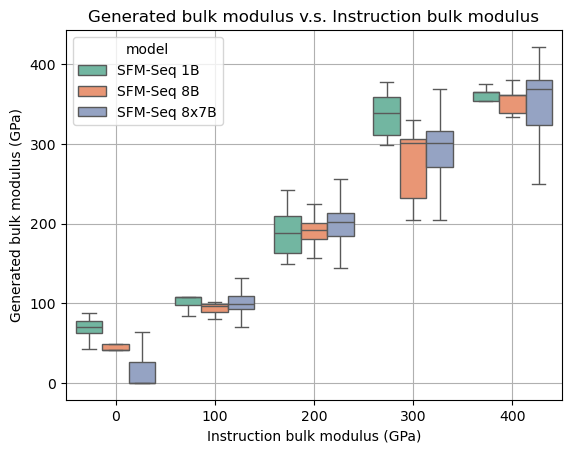

In [6]:
plot_all(novelty=False)
#plot_all(novelty=True)

/tmp/ipykernel_2924806/352126463.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Instruction bulk modulus", y="Generated bulk modulus", data=df, palette="Set2", legend=False)


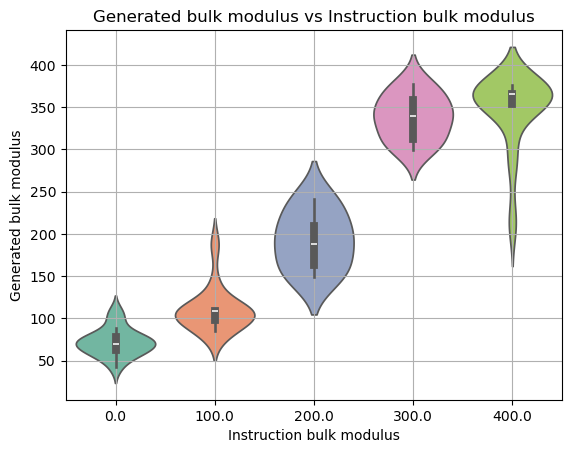

/tmp/ipykernel_2924806/352126463.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Instruction bulk modulus", y="Generated bulk modulus", data=df, palette="Set2", legend=False)


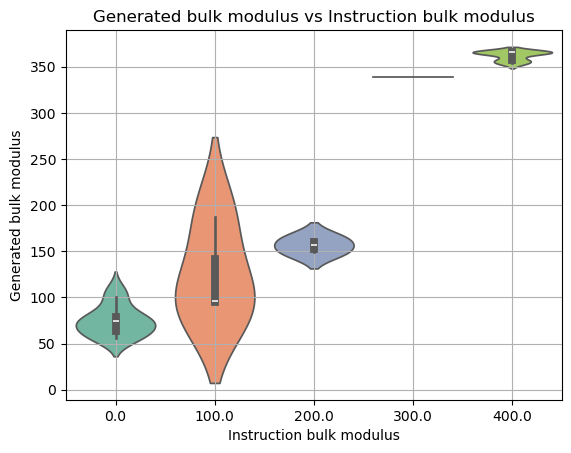

Total: 147
Novel: 77
Novel rate: 77/147 = 0.5238


In [40]:
plot(0)
plot(0, True)

/tmp/ipykernel_2924806/352126463.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Instruction bulk modulus", y="Generated bulk modulus", data=df, palette="Set2", legend=False)


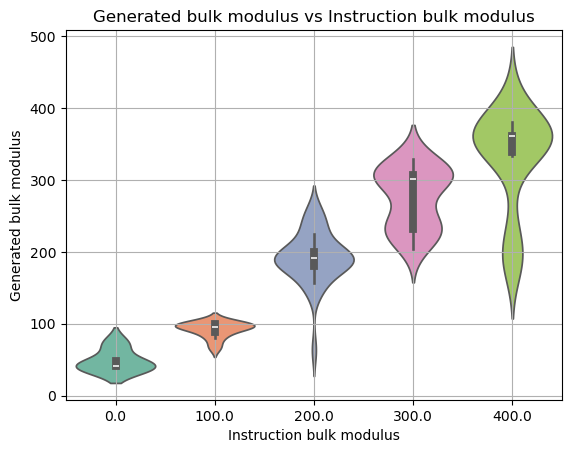

/tmp/ipykernel_2924806/352126463.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Instruction bulk modulus", y="Generated bulk modulus", data=df, palette="Set2", legend=False)


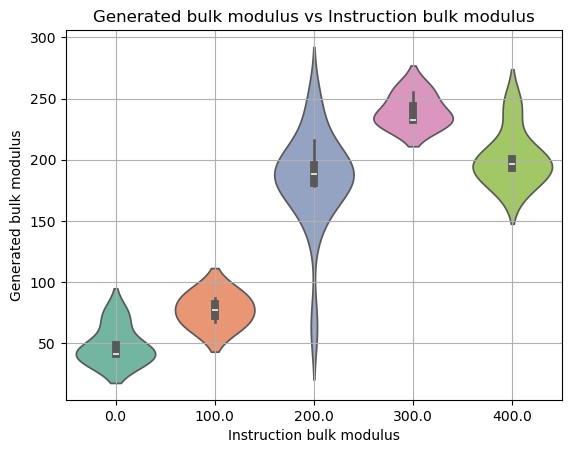

Total: 157
Novel: 57
Novel rate: 57/157 = 0.3631


In [41]:
plot(1)
plot(1, True)

/tmp/ipykernel_2924806/352126463.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Instruction bulk modulus", y="Generated bulk modulus", data=df, palette="Set2", legend=False)


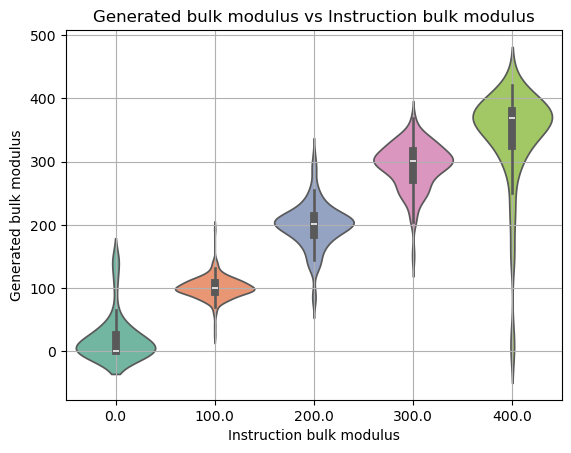

/tmp/ipykernel_2924806/352126463.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Instruction bulk modulus", y="Generated bulk modulus", data=df, palette="Set2", legend=False)


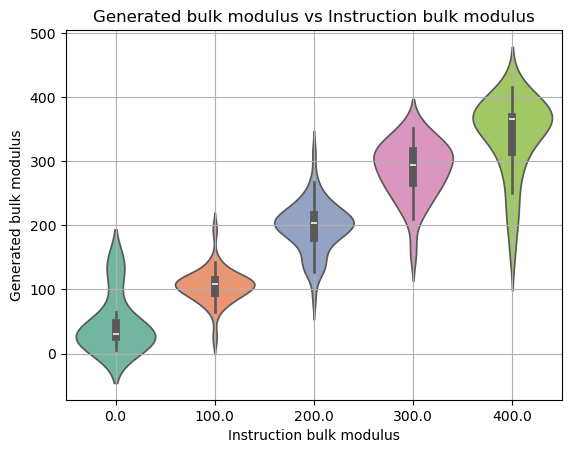

Total: 1422
Novel: 461
Novel rate: 461/1422 = 0.3242


In [42]:
plot(2)
plot(2, True)

/tmp/ipykernel_2924806/352126463.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Instruction bulk modulus", y="Generated bulk modulus", data=df, palette="Set2", legend=False)


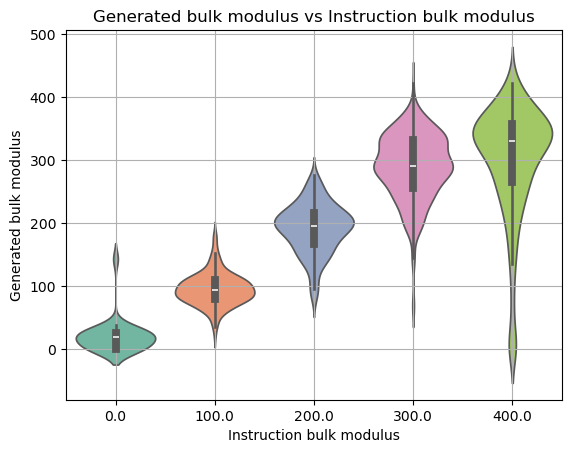

/tmp/ipykernel_2924806/352126463.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Instruction bulk modulus", y="Generated bulk modulus", data=df, palette="Set2", legend=False)


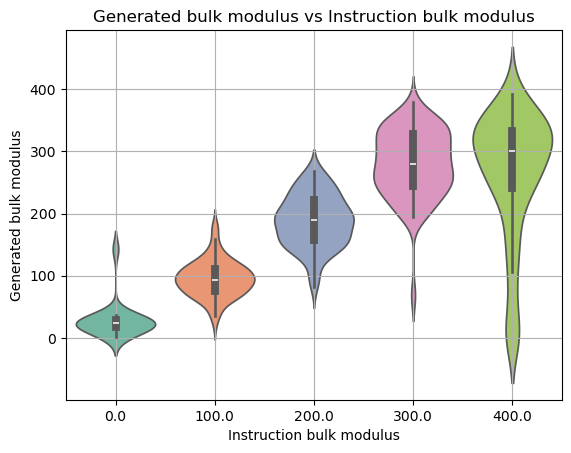

Total: 2310
Novel: 1363
Novel rate: 1363/2310 = 0.5900


In [43]:
plot(3)
plot(3, True)